**Baseline Models for Time Series Forecasting:**
This notebook demonstrates the implementation of baseline models for time series forecasting using the `statsforecast` library. We will cover the following models:
2. Naive
1. Seasonal Average
3. Seasonal Naive
4. Window Average

Use of baseline models:\
**Baseline models** are essential in time series forecasting as they provide a simple reference point against which more complex models can be compared. \
They help in understanding the inherent patterns in the data and set a benchmark for evaluating the performance of advanced forecasting techniques. \
By establishing a baseline, we can determine whether sophisticated models offer significant improvements in accuracy and reliability over simpler approaches.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from utilsforecast.losses import *
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/youtube_tutorials/refs/heads/main/data/daily_sales_french_bakery.csv')
df.head(3)

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0


In [8]:
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(columns=['unit_price'])
df.tail()

,unique_id,ds,y
57041,VIK BREAD,2022-09-26,0.0
57042,VIK BREAD,2022-09-27,0.0
57043,VIK BREAD,2022-09-28,0.0
57044,VIK BREAD,2022-09-29,0.0
57045,VIK BREAD,2022-09-30,32.4


In [9]:
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56904 entries, 0 to 57045
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  56904 non-null  object        
 1   ds         56904 non-null  datetime64[ns]
 2   y          56904 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.7+ MB


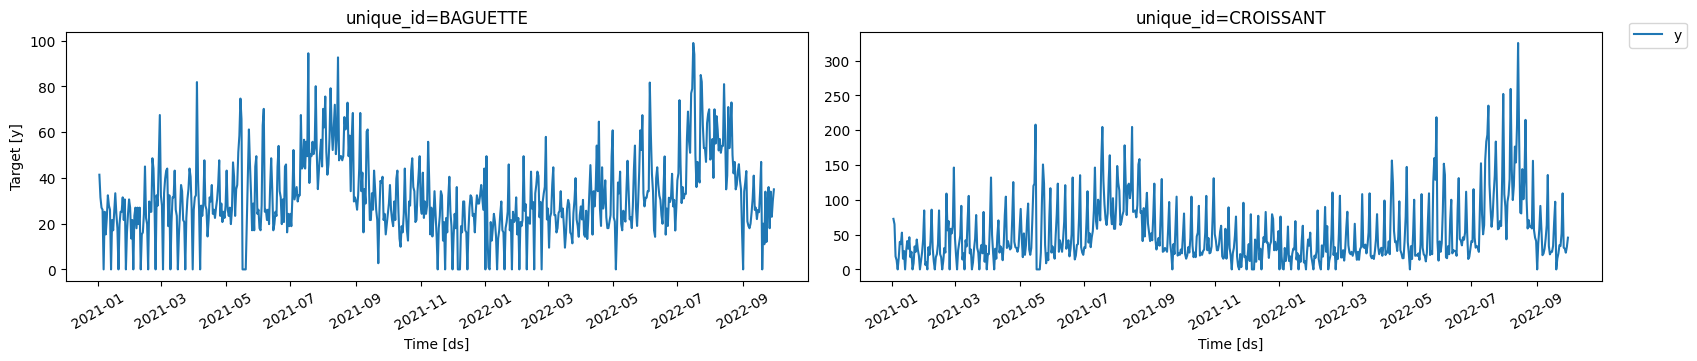

In [10]:
plot_series(df=df, ids=['BAGUETTE','CROISSANT'], palette='tab10')

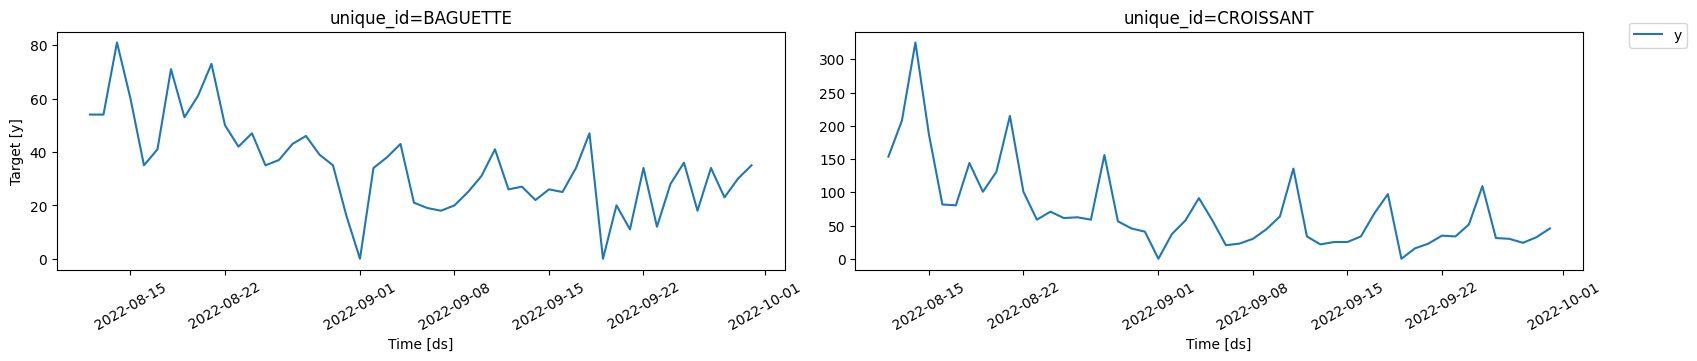

In [11]:
plot_series(df=df, ids=['BAGUETTE','CROISSANT'], max_insample_length=50, palette='tab10')

In [12]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [13]:
horizon = 7
models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]
sf = StatsForecast(models=models, freq='D', n_jobs=-1)
sf.fit(df=df)
preds = sf.predict(h=horizon)
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


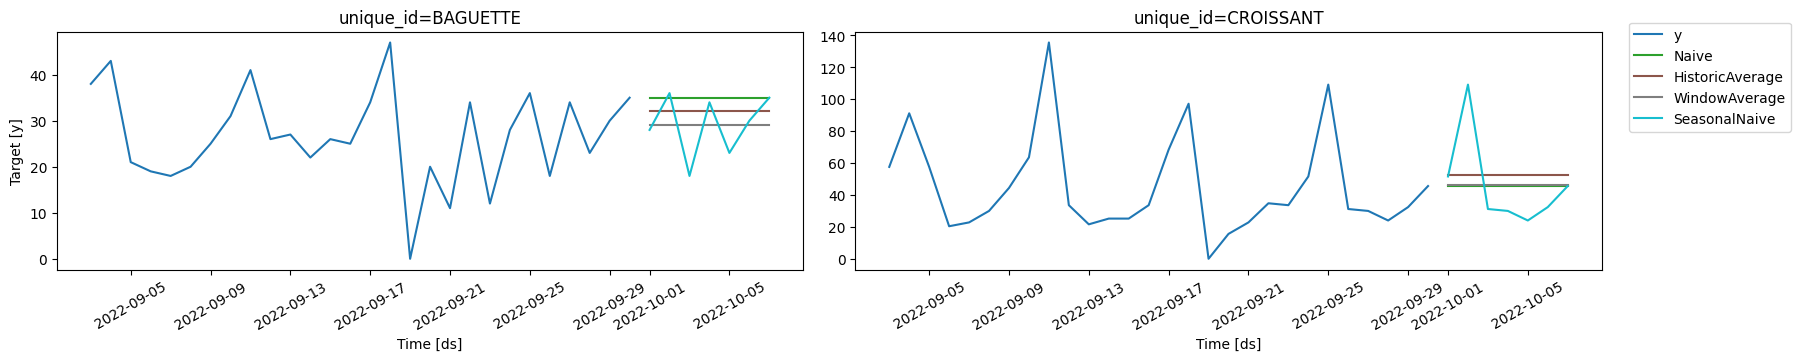

In [14]:
plot_series(df=df,
            forecasts_df=preds,
            ids=['BAGUETTE','CROISSANT'],
            max_insample_length=28,
            palette='tab10')

In [15]:
#Evaluation
test = df.groupby('unique_id').tail(7)
train = df.drop(test.index).reset_index(drop=True)
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, how='left', on=['unique_id','ds'])

In [16]:
#import mae from utilsforecast.losses
from utilsforecast.losses import mae

evaluation = evaluate(
    eval_df,
    metrics=[mae])
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [17]:
evaluation = evaluation.drop('unique_id', axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


--------------------------------------------------------------------------------------------------------------

**ARIMA** is a popular statistical method used for time series forecasting. It stands for `AutoRegressive Integrated Moving Average`. 
ARIMA models are particularly **useful** for analyzing and forecasting time series data that may exhibit non-stationarity, trends, and seasonality.
The ARIMA model is characterized by three main parameters:
1. **AutoRegressive (AR) term (p)**: This parameter represents the number of lagged observations included in the model. It captures the relationship between the current value and its previous values.
2. **Integrated (I) term (d)**: This parameter indicates the number of times the data needs to be differenced to make it stationary. Differencing is a technique used to remove trends and seasonality from the data.
3. **Moving Average (MA) term (q)**: This parameter represents the number of lagged forecast errors included in the model. It captures the relationship between the current value and past forecast errors.

Arima typically involves the following steps:
1. **Data Preparation**: Collect and preprocess the time series data, ensuring it is in a suitable format for analysis.
2. **Stationarity Check**: Use statistical tests (e.g., Augmented Dickey-Fuller test) to check if the time series is stationary. If not, apply differencing to make it stationary.
3. **Model Identification**: Use techniques like Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to identify the appropriate values for p, d, and q.
4. **Model Estimation**: Fit the ARIMA model to the data using statistical software or programming languages like Python or R.
5. **Model Diagnostics**: Evaluate the model's performance using residual analysis and statistical tests to ensure that the residuals are white noise.
6. **Forecasting**: Use the fitted ARIMA model to make future predictions based on the historical data.
ARIMA models are widely used in various fields, including finance, economics, and environmental science, for forecasting stock prices, economic indicators, and weather patterns, among others.

**Parameters** of the model:
- **p**: The number of lag observations included in the model (the order of the autoregressive part).
- **d**: The number of times that the raw observations are differenced (the degree of differencing).
- **q**: The size of the moving average window (the order of the moving average part).


In [18]:
from statsforecast.models import AutoARIMA

In [21]:
unique_ids = ['BAGUETTE','CROISSANT']
small_train = train[train['unique_id'].isin(unique_ids)]
small_test = test[test['unique_id'].isin(unique_ids)]


In [24]:
models = [
    AutoARIMA(season_length=False, alias='ARIMA'),
    AutoARIMA(season_length=7, alias='SARIMA')
]

In [25]:
sf_arima = StatsForecast(models=models, freq='D', n_jobs=-1)
sf_arima.fit(df=small_train)
preds_arima = sf_arima.predict(h=horizon)

In [28]:
arima_eval_df = pd.merge(small_test, preds_arima, how='inner', on=['unique_id','ds'])
arima_evaluation = evaluate(arima_eval_df, metrics=[mae])
arima_evaluation = arima_evaluation.drop('unique_id', axis=1).groupby('metric').mean().reset_index()
arima_evaluation

,metric,ARIMA,SARIMA
0,mae,11.959274,8.904113


**SARIMA** perfomed better than ARIMA in capturing the seasonal patterns in the data. \
**SARIMA** (Seasonal ARIMA) is an extension of the ARIMA model that explicitly accounts for seasonality in time series data. It incorporates additional seasonal terms to capture patterns that repeat at regular intervals, such as monthly or yearly cycles.